# AV2 - Redes Convolucionais

### Alunos

- Tiago Silva
- Yasmin Romi

## Overview

***Redes Neurais Convolucionais***: Utilizada amplamente no reconhecimento de imagens, uma rede neural convolucional (CNN do inglês Convolutional Neural network ou ConvNet) é uma classe de rede neural artificial do tipo feed-forward, que vem sendo aplicada com sucesso no processamento e análise de imagens digitais.

Iremos dividir em duas etapas onde serão aplicadas técnicas diferentes em cima do mesmo conjunto de dados. Devermos abordar esse problema de duas maneiras:

- Criando uma rede neural completamente conectacada de uma única camada oculta e com uma camada de saída de duas unidades com softmax
- Uma rede convolucional

# Rede Completamente Conectada

### Questões

**Neurônios na camada escondida ?**

64 na camada oculta
2 neurônios na camada de Saída

**Quantas Camadas?**

Utilizaremos Duas Camadas, sendo uma camada oculta e uma camada de saída.

**Com Regularização? Qual?**

Não.
Uma forma de lidar com o overfitting pra nossa rede completamente conectada seria adicionar uma regularização a ela. No entanto, isso faria com que tivessemos que adicionais mais camadas a rede e deixaríamos de ter a arquitetura pedida pelo trabalho, portanto, manteremo-as como apresentada acima.

**Qual a melhor taxa de aprendizado?**

**Qual a função de ativação usada ?**

Na Camada de Saída, utilizamos a *softmax*
Na Camada escondida, utlizaremos a *relu*

## Preparações

Faremos a implementação utilizando o [Keras](https://www.tensorflow.org/guide/keras), uma API para modelagem de redes neurais que roda por cima dos principais frameworks de redes neurais. No nosso caso, o framework utilizado como base será o TensowFlow. 

In [2]:
# Tensoflow and keras
import tensorflow as tf
from keras import backend as K
import keras

# Utilities
import numpy as np
import h5py
import random as rn
import os

# Comando necessário para que o código tenha reproducibilidade
# para certas operações hash-based
os.environ['PYTHONHASHSEED'] = '0'

# Comando necessário para inicializar valores randômicos gerados pelo Numpy
np.random.seed(42)

# Comando necessário para inicializar valores randômicos gerados pelo Python
rn.seed(12345)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



def load_dataset():
    train_dataset = h5py.File('./../data/train_catvnoncat.h5', 'r')
    
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('./../data/test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape(-1, train_set_y_orig.shape[0])
    test_set_y_orig = test_set_y_orig.reshape(-1, test_set_y_orig.shape[0])

    return (train_set_x_orig, train_set_y_orig, test_set_x_orig,
            test_set_y_orig, classes)


# Carregando os datasets de treinamento e teste
train_set_x, train_set_y, test_set_x, test_set_y, classes = load_dataset()
train_set_y = train_set_y.reshape(-1, 1)
test_set_y = test_set_y.reshape(-1, 1)

Using TensorFlow backend.


In [6]:
from keras.utils import to_categorical

def preprocessing_neural(x, y):
    # Função para aplicar pré-processamento nos vetores
    # de features e target

    # Achatando o número de dimensões do vetor de features
    # Isso significa que estamos transformando nossa matriz de imagens de 64x64 num vetor
    # no formato (nSamples, 64x64) que será servido para a rede neural como uma única feature
    x_flatten = x.reshape(x.shape[0], -1)

    # Normalizando os valores de RGB para ficarem entre 0 e 1
    x_flatten = x_flatten.astype('float32')
    x_flatten = x_flatten/255

    # Transformando os valores inteiros de y em categorias
    # por ser o formato necessário para o Keras realizar a
    # classificação de múltiplas classes
    y_cat = to_categorical(y)

    return x_flatten, y_cat


# Aplicando pré-processamento nos vetores de features
train_set_x, train_set_y = preprocessing_neural(train_set_x, train_set_y)
test_set_x, test_set_y = preprocessing_neural(test_set_x, test_set_y)
print(train_set_x.shape)
print(train_set_y.shape)
input_shape = train_set_x.shape[1:]
print(input_shape)

(209, 12288)
(209, 2)
(12288,)


Agora que temos nossos conjuntos de dados carregados e pré-processado, o próximo passo é a modelagem da rede neural completamente conectada. Essa rede deverá conter apenas uma camada oculta e uma camada de saída com 2 neurônios usando a função de ativação `softmax`. 

Por conta disso, a nível de arquitetura da rede, só temos dois parâmetros para escolher: a quantidade de neurônios e a função de ativação da camada oculta.

A escolha do número de neurônios se deu através de testes baseado em exemplos de redes encontradas na internet que visam executar um trabalho semelhante.

A função de ativação utilizada foi a `relu` pois tem sido a função de ativação padrão para esse tipo de rede atualmente por ser a que apresenta melhores resultados.

Em relação ao otimizador, os testes foram feitos principalmente utilizando o `rmsprop` e o `sgd`.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

def create_model_neural(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(2, activation='softmax'))
    return model


def train_model_neural(model, x_train, y_train, x_test, y_test, batch, epoch):
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(x_train, y_train, batch_size=batch, epochs=epoch,
                        validation_data=(x_test, y_test), shuffle=False)
    return history

# Criando o modelo de rede neural para predição
batch_size = 15
epochs = 100
model = create_model_neural(input_shape)
hist_neural = train_model_neural(model, train_set_x, train_set_y,
                                 test_set_x, test_set_y,
                                 batch_size, epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                786496    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 786,626
Trainable params: 786,626
Non-trainable params: 0
_________________________________________________________________
None
Train on 209 samples, validate on 50 samples
Epoch 1/100
209/209 [==============================] - 0s 2ms/step - loss: 5.2208 - acc: 0.6268 - val_loss: 10.6379 - val_acc: 0.3400
Epoch 2/100
209/209 [==============================] - 0s 949us/step - loss: 6.0351 - acc: 0.5407 - val_loss: 10.6328 - val_acc: 0.3400
Epoch 3/100
209/209 [==============================] - 0s 1ms/step - loss: 3.5341 - acc: 0.5550 - val_loss: 5.6479 - val_acc: 0.3400
Epoch 4/100
209/209 [==============================] - 0s 869us/step - loss: 1.

Abaixo iremos avaliar a performance da nossa rede completamente conectada através dos valores de perda (*loss*) e acurácia (*accuracy*).

50/50 [==============================] - 0s 140us/step
Loss value: 1.2115476655960082
Accuracy: 0.7000000071525574


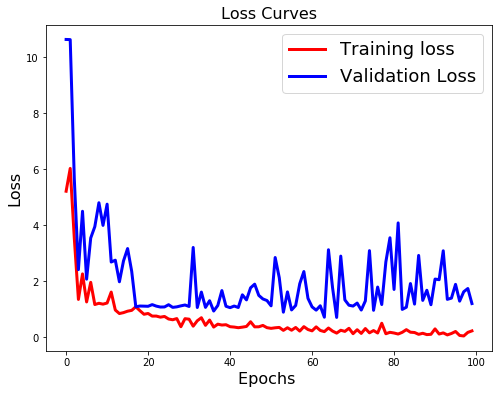

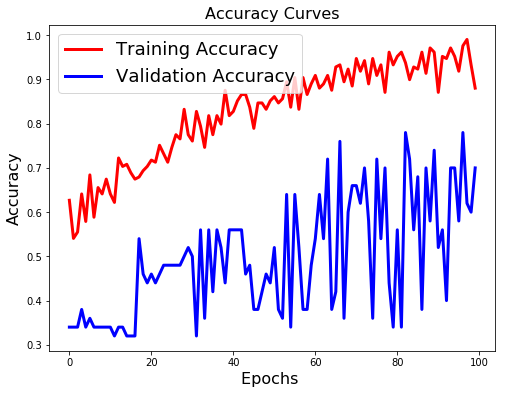

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

def evaluate_model(model, x, y):
    score = model.evaluate(x, y)
    print('Loss value: {}'.format(score[0]))
    print('Accuracy: {}'.format(score[1]))


def plot_accuracy(history):
    # Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['loss'], 'r', linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.show()

    # Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['acc'], 'r', linewidth=3.0)
    plt.plot(history.history['val_acc'], 'b', linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)
    plt.show()
    

evaluate_model(model, test_set_x, test_set_y)
plot_accuracy(hist_neural)

Olhando unicamente para os números, nossa perda no conjunto de validação foi de **1.21** e nossa acurácia foi de 0.70, o que não é ruim. No entanto, ao observar os gráficos plotados podemos tirar algumas conclusões mais precisas sobre a nossa rede.

Tanto no gráfico de perda quanto no de acurácia, as linhas do conjunto de treinamento e validação estão bastante distantes umas das outras. Além disso, no gráfico de perda podemos ver inicialmente uma queda no erro no conjunto de validação (até próximo da *epoch* 20) mas depois o erro se estabiliza e passa a ter picos de subida ao invés de seguir uma curva descendente como no conjunto de treinamento. Esses são indícios de que nossa rede está sofrente de *overfitting*, ou seja, o modelo "decorou" o conjunto de treinamento, mas não vai bem quando apresentamos dados não vistos antes por ele (durante o treinamento).

# Rede Convulacional

Agora vamos modelar e treinar nossa rede convolucional. Iremos realizar novamente o processo de leitura e pré-processamento dos dados. 

O de leitura para garantir que estamos trabalhando com o conjunto de dados base e o pré-processamento pois ele é diferente para a rede convolucional.

### Questões

**Neurônios na camada escondida ?

256 na camada oculta
2 neurônios na camada de Saída

**Quantas Camadas?

Utilizaremos Duas Camadas, sendo uma camada oculta e uma camada de saída (completamente conectadas).

**Com Regularização? Qual?

Sim.
Utilizamos Dropout e Pooling.

**Qual a melhor taxa de aprendizado?

**Qual a função de ativação usada ?

Na Camada de Saída, utilizamos a *softmax*
Na Camada escondida, utlizaremos a *relu*

In [9]:
# Leitura do conjunto de dados de treinamento
train_set_x, train_set_y, test_set_x, test_set_y, classes = load_dataset()
train_set_y = train_set_y.reshape(-1, 1)
test_set_y = test_set_y.reshape(-1, 1)

In [10]:
def preprocessing_cnn(x, y):
    # Função para aplicar pré-processamento nos vetores
    # de features e target

    # Normalizando os valores de RGB para ficarem entre 0 e 1
    x_flatten = x.astype('float32')
    x_flatten = x_flatten/255

    # Transformando os valores inteiros de y em categorias
    # por ser o formato necessário para o Keras realizar a
    # classificação de múltiplas classes
    y_cat = to_categorical(y)

    return x_flatten, y_cat

# Aplicando pré-processamento nos vetores de features
train_set_x, train_set_y = preprocessing_cnn(train_set_x, train_set_y)
test_set_x, test_set_y = preprocessing_cnn(test_set_x, test_set_y)
print(train_set_x.shape)
print(train_set_y.shape)
input_shape = train_set_x[0].shape
print(input_shape)

(209, 64, 64, 3)
(209, 2)
(64, 64, 3)


Tendo os dados carregados e pré-processados, podemos modelar e treinar a rede convolucional. A processo de modelagem dela e de encontrar os hiperparâmetros que teriam um melhor resultado foi mais complexo por não ter sido dada indicação do formato da rede como foi feito para a rede completamente conectada. Mais uma vez, a abordagem utilizada foi a de buscar exemplos na internet que atacavam problemas semelhantes e, à partir deles, ir fazendo alterações na arquitetura até que fosse atingido um resultado satisfatório.

In [11]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

def create_model_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu',
              input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model


def train_model_cnn(model, x_train, y_train, x_test, y_test, batch, epoch):
    model.compile(optimizer='sgd', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(x_train, y_train, batch_size=batch, epochs=epoch,
                        validation_data=(x_test, y_test), shuffle=False)
    return history

# Criando o modelo de rede neural para predição
batch_size = 10
epochs = 100
model = create_model_cnn(input_shape)
hist_cnn = train_model_cnn(model, train_set_x, train_set_y,
                           test_set_x, test_set_y,
                           batch_size, epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
__________

209/209 [==============================] - 5s 23ms/step - loss: 0.3390 - acc: 0.8517 - val_loss: 0.4686 - val_acc: 0.8400
Epoch 50/100
209/209 [==============================] - 5s 23ms/step - loss: 0.3103 - acc: 0.8852 - val_loss: 0.4016 - val_acc: 0.8800
Epoch 51/100
209/209 [==============================] - 5s 22ms/step - loss: 0.3227 - acc: 0.8612 - val_loss: 0.4522 - val_acc: 0.8200
Epoch 52/100
209/209 [==============================] - 5s 24ms/step - loss: 0.3176 - acc: 0.8660 - val_loss: 0.4094 - val_acc: 0.9000
Epoch 53/100
209/209 [==============================] - 6s 28ms/step - loss: 0.3008 - acc: 0.8660 - val_loss: 0.4282 - val_acc: 0.8600
Epoch 54/100
209/209 [==============================] - 5s 26ms/step - loss: 0.3121 - acc: 0.8708 - val_loss: 0.4821 - val_acc: 0.8400
Epoch 55/100
209/209 [==============================] - 5s 25ms/step - loss: 0.3125 - acc: 0.8660 - val_loss: 0.4124 - val_acc: 0.9000
Epoch 56/100
209/209 [==============================] - 5s 24ms/step

A rede convolucional modelada possuí uma arquitetura de 10 camadas, dividas da seguinte forma:

- 2 camadas convolucionais de 2 dimensões
- 2 camadas de pooling (utiliando Max Pooling)
- 3 camadas de dropout
- 1 camada Flatten
- 2 camadas densas (completamente conectadas)

As camadas convolucionais são, como o próprio nome nos dá a entender, as principais camadas desse tipo de rede. Nessas camadas o que acontece, resumidamente, é um aprendizado de filtros por parte da rede, que irá percorrer a entrada que lhe for dada e irá "ativar" quando encontrar algum padrão que esteja de acordo com os filtros aprendidos.

Geralmente entre camadas convolucionais são adicionadas camada de pooling. Essas camadas tem como função a diminuição progressiva do tamanho espacial para que se tenham menos parâmetros e computações sendo processadas na rede. Outra utilidade dessa camada é o controle de *overfitting* que, como dito anteriormente, acontece quando uma rede "decora" os parâmetros em que foi treinada e não conseguir fazer uma generalização para um outro conjunto de dados que venha a ser apresentado a ela.

Outra maneira de combater o *overfitting* é através da adição de camadas de *dropout*. Nessas camadas algumas entradas são selecionados randômicamente para que sejam desligadas da rede, o que torna mais difícil que a rede que está sendo treinada fique totalmente aderente a um conjunto de treinamento.

A camada *Flatten* server para adequar os dados produzidos nas camadas de convolução para serem servidos para as camadas completamente conectadas, que são as responsáveis por produzir a classificação que será a saída do modelo. Ela funciona da mesma forma que numa rede completamente conectada, aonde temos que realizar essa operação com o mesmo objetivo.

Como dito anteriormente, tanto essa arquitetura quanto os parãmetros de cada camada foram descobertos à partir de modelos encontrados na internet que visavam resolver problemas de classificação semelhantes ao nosso. Foram feitos uma série de testes manuais com diferentes combinações de parâmetros em cada camada para chegar até o modelo final. Vamos ver qual foi o resultado desse modelo.

50/50 [==============================] - 0s 5ms/step
Loss value: 0.34498459339141846
Accuracy: 0.9399999904632569


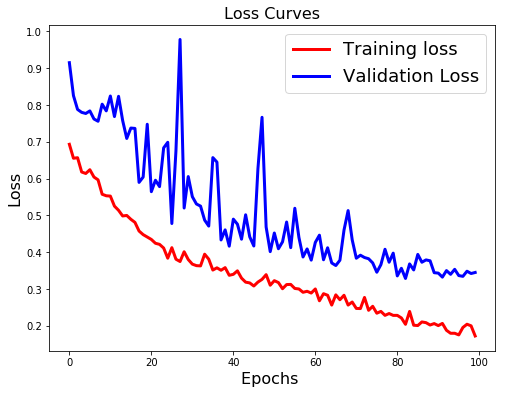

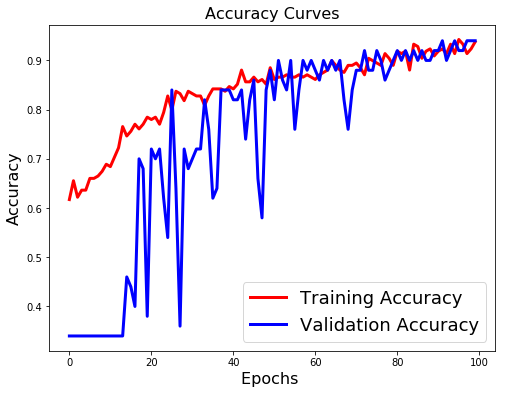

In [12]:
evaluate_model(model, test_set_x, test_set_y)
plot_accuracy(hist_cnn)

# Conclusões

### Rede Completamente Conectada

**Loss**: 1.2
**Accuracy**: 0.7

### Rede Covulacional:

**Loss**: 0.3
**Accuracy**: 0.9

A rede convolucional apresenta uma performance muito melhor do que a rede neural completamente conectada que treinamos na etapa anterior desse trabalho, atingindo uma perda de 0.34 e uma acurácia de praticamente 94%. 

Olhando para o gráfico da acurácia podemos ver que a rede generalizou bem, tendo desempenho muito semelhante no conjunto de treinamento e validação. No entanto, o gráfico de erro nos mostra uma certa distância entre os dois conjuntos de dados. 

Poderíamos tentar diminuir essa distância através de aplicações de técnicas como  aumento dos dados (*data augmentation*), mas a fim de simplificação, optamos por não utilizá-los.

## Referências

- [Rede Neuural Convolucional](https://pt.wikipedia.org/wiki/Rede_neural_convolucional)
- [Documentação do Keras](https://keras.io/)
- [Repositório do HDF5](https://github.com/h5py/h5py)
- [CS231n - Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)
- [Learn OpenCV](https://www.learnopencv.com/)